<a href="https://colab.research.google.com/github/joshuabusinge/deeplearning_chestopacity/blob/main/ChestOpacity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### IMPORT LIBRARIES

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#### MOUNT GOOGLE DRIVE

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#import pathlib
dataset_1 = "/content/drive/MyDrive/MASTERS DEGREE/Makerere Unversity/SEM 2/Deep Learning/dataset1"
training_ds = tf.keras.utils.image_dataset_from_directory(dataset_1, validation_split=0.2,shuffle=False,
  color_mode='rgb', subset="training", seed=123, image_size=(150, 150), batch_size=50)

# data_dir = pathlib.Path(dataset_1)

Found 715 files belonging to 2 classes.
Using 572 files for training.


In [4]:
class_names = training_ds.class_names
print(class_names)

['normal', 'sick']


In [5]:
valid_ds = tf.keras.utils.image_dataset_from_directory(dataset_1, validation_split=0.2, shuffle=False,
  color_mode='rgb', subset="validation", seed=123, image_size=(150, 150), batch_size=20)


Found 715 files belonging to 2 classes.
Using 143 files for validation.


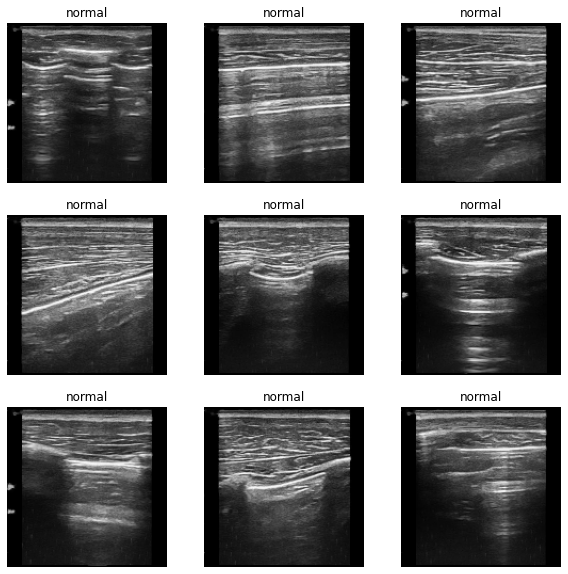

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in training_ds:
  print(image_batch.shape)
  
  break

(50, 150, 150, 3)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

training_ds = training_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
# Normalize pixel values to be between 0 and 1
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = training_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[3]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 


0.0 0.9756448


Creating the CNN Model for prediction

In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(150, 150, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(), 
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),
  #layers.Dense(num_classes, activation = 'softmax')
])



Compile the Model

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model Summary

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        1

Train the Model

In [14]:
epochs=10
history = model.fit(
  training_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/10
12/12 [==============================] - 8s 174ms/step - loss: 1.4491 - accuracy: 0.4790 - val_loss: 0.7018 - val_accuracy: 0.0420
Epoch 2/10
12/12 [==============================] - 0s 34ms/step - loss: 0.6851 - accuracy: 0.6416 - val_loss: 0.7098 - val_accuracy: 0.0140
Epoch 3/10
12/12 [==============================] - 0s 35ms/step - loss: 0.6791 - accuracy: 0.6643 - val_loss: 0.7163 - val_accuracy: 0.0629
Epoch 4/10
12/12 [==============================] - 0s 26ms/step - loss: 0.6602 - accuracy: 0.6713 - val_loss: 0.7467 - val_accuracy: 0.1399
Epoch 5/10
12/12 [==============================] - 0s 26ms/step - loss: 0.6175 - accuracy: 0.6976 - val_loss: 0.6683 - val_accuracy: 0.5315
Epoch 6/10
12/12 [==============================] - 0s 26ms/step - loss: 0.5272 - accuracy: 0.7937 - val_loss: 0.6758 - val_accuracy: 0.5245
Epoch 7/10
12/12 [==============================] - 0s 27ms/step - loss: 0.5298 - accuracy: 0.7168 - val_loss: 0.9020 - val_accuracy: 0.3986
Epoch 8/10
1

Visualize training results

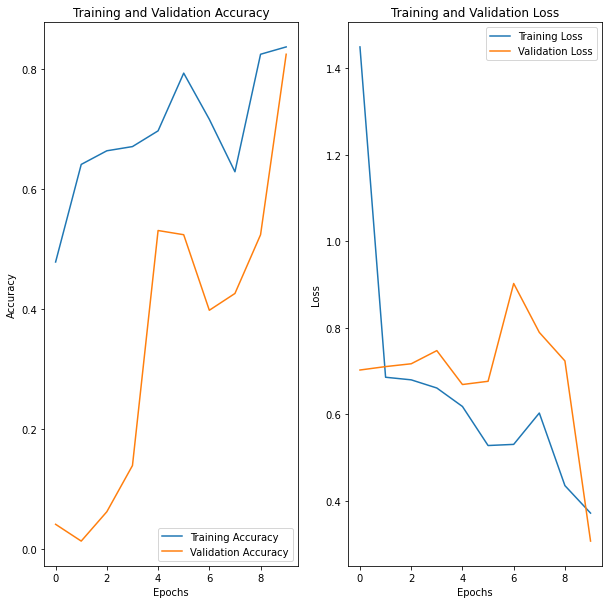

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
valid_loss,valid_acc = model.evaluate(valid_ds)
print(valid_loss)
print(valid_acc)

training_loss,training_acc = model.evaluate(training_ds)
print(training_loss)
print(training_acc)


8/8 [==============================] - 0s 6ms/step - loss: 0.3062 - accuracy: 0.8252
0.3061772882938385
0.8251748085021973
12/12 [==============================] - 0s 11ms/step - loss: 0.2889 - accuracy: 0.9108
0.28892022371292114
0.9108391404151917


Data augmentation

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(150,
                                  150,
                                  3)),
    layers.RandomRotation(0.0),
    layers.RandomZoom(0.3),
  ]
)

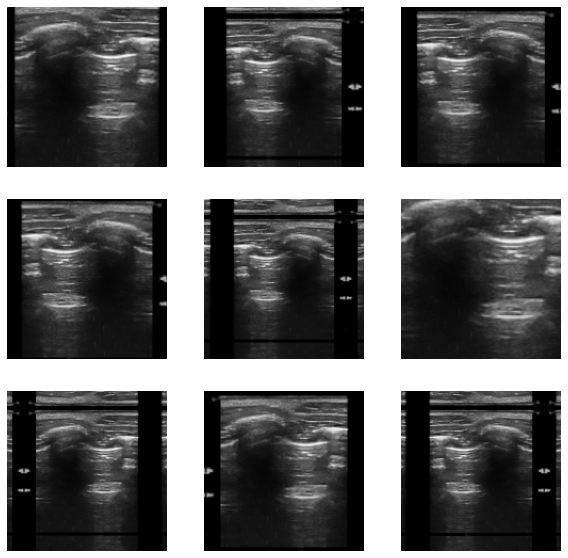

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in training_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Dropout

In [19]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                  

In [22]:
epochs = 10
history = model.fit(
  training_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/10
12/12 [==============================] - 1s 46ms/step - loss: 0.9710 - accuracy: 0.5087 - val_loss: 0.6939 - val_accuracy: 0.3147
Epoch 2/10
12/12 [==============================] - 0s 29ms/step - loss: 0.6869 - accuracy: 0.6538 - val_loss: 0.7121 - val_accuracy: 0.0070
Epoch 3/10
12/12 [==============================] - 0s 30ms/step - loss: 0.6573 - accuracy: 0.6399 - val_loss: 0.8640 - val_accuracy: 0.0000e+00
Epoch 4/10
12/12 [==============================] - 0s 29ms/step - loss: 0.5925 - accuracy: 0.6416 - val_loss: 1.0901 - val_accuracy: 0.0699
Epoch 5/10
12/12 [==============================] - 0s 29ms/step - loss: 0.5996 - accuracy: 0.7028 - val_loss: 0.8043 - val_accuracy: 0.4755
Epoch 6/10
12/12 [==============================] - 0s 29ms/step - loss: 0.5117 - accuracy: 0.7325 - val_loss: 1.2821 - val_accuracy: 0.2238
Epoch 7/10
12/12 [==============================] - 0s 29ms/step - loss: 0.4268 - accuracy: 0.8007 - val_loss: 0.5536 - val_accuracy: 0.7622
Epoch 8/1

Visualize training results

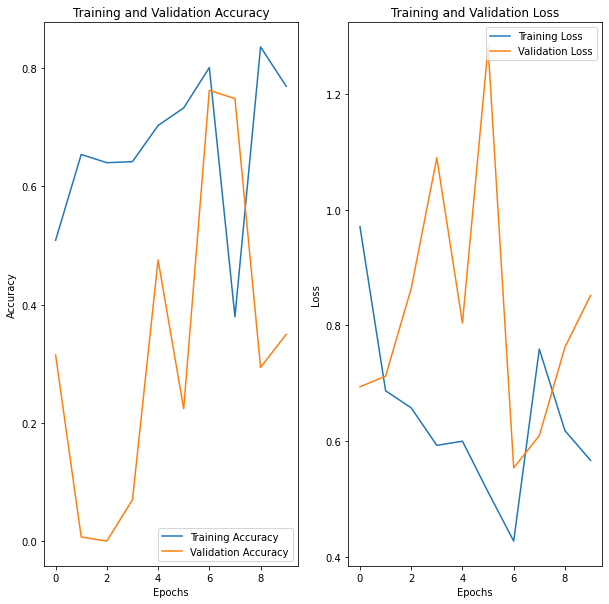

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
valid_loss,valid_acc = model.evaluate(valid_ds)
print(valid_loss)
print(valid_acc)

training_loss,training_acc = model.evaluate(training_ds)
print(training_loss)
print(training_acc)

8/8 [==============================] - 0s 6ms/step - loss: 0.8519 - accuracy: 0.3497
0.8518572449684143
0.3496503531932831
12/12 [==============================] - 0s 11ms/step - loss: 0.4925 - accuracy: 0.7762
0.49248403310775757
0.7762237787246704


In [25]:
y_pred = []
y_true = []

for image_batch, label_batch in valid_ds:

  y_true.append(label_batch)

  predictions = model.predict(image_batch)

  y_pred.append(np.argmax(predictions, axis = -1))

correct_labels = tf.concat([item for item in y_true],axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis =0)

from sklearn.metrics._plot.confusion_matrix import confusion_matrix
cm=confusion_matrix(predicted_labels,correct_labels)
print(cm)

[[ 0 93]
 [ 0 50]]


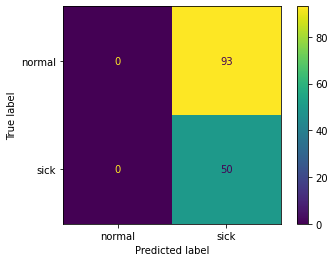

In [26]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = class_names)
disp.plot()

plt.show()

#### Test of one image in known data

In [27]:
dataset_1 = "/content/drive/MyDrive/MASTERS DEGREE/Makerere Unversity/SEM 2/Deep Learning/dataset1/normal/normal_0.png"
#test_ds = tf.keras.utils.get_file('sick', origin = dataset_1 )

img = tf.keras.utils.load_img(dataset_1, target_size=(150, 150))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to normal with a 70.78 percent confidence.


#### Dataset 1 of unknown data

Found 50 files belonging to 1 classes.
Predictions:
 [0 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0]


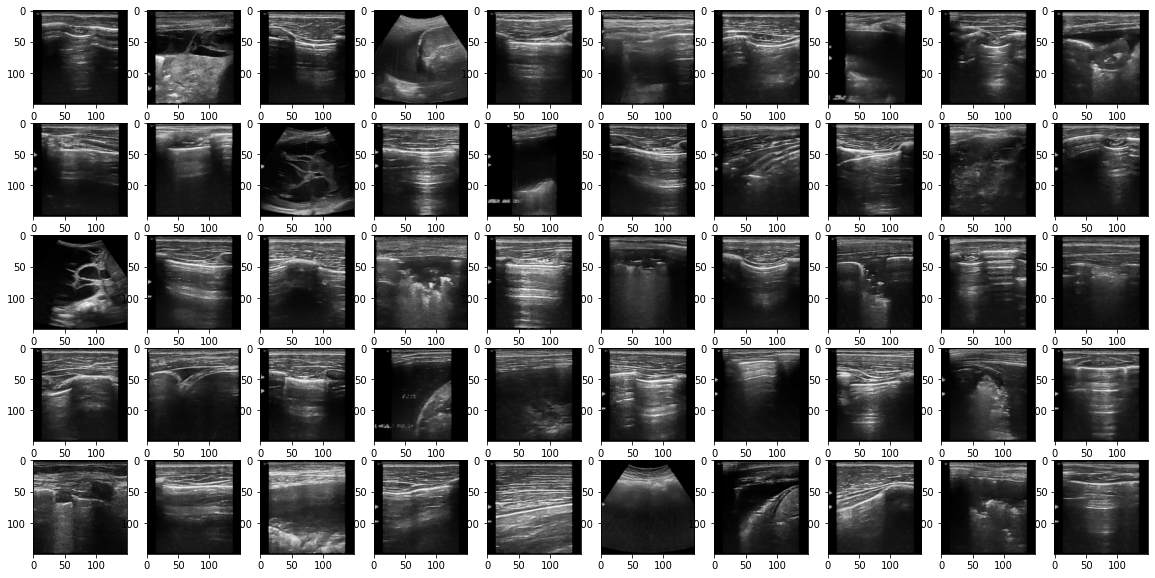

In [28]:
dataset_1 = "/content/drive/MyDrive/MASTERS DEGREE/Makerere Unversity/SEM 2/Deep Learning/unknown_images"
test_ds = tf.keras.utils.image_dataset_from_directory(dataset_1,  shuffle=False,
  color_mode='rgb', image_size=(150, 150), batch_size=50)

AUTOTUNE = tf.data.AUTOTUNE

test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,1)
#predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
#print('Labels:\n', label_batch)

plt.figure(figsize=(20, 10))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  

In [29]:
import pandas as pd
import numpy as np
  
  
# convert array into dataframe
DF = pd.DataFrame(predictions)
  
# save the dataframe as a csv file
DF.to_csv("image_results.csv")

In [30]:
test_loss,test_acc = model.evaluate(test_ds)
print(test_loss)
print(test_acc)

1/1 [==============================] - 0s 43ms/step - loss: 0.4889 - accuracy: 0.8200
0.48888838291168213
0.8199999928474426


In [31]:
y_pred = []
y_true = []

for image_batch, label_batch in test_ds:

  y_true.append(label_batch)

  predictions = model.predict(image_batch)

  y_pred.append(np.argmax(predictions, axis = -1))

correct_labels = tf.concat([item for item in y_true],axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis =0)

from sklearn.metrics._plot.confusion_matrix import confusion_matrix
test_cm=confusion_matrix(predicted_labels,correct_labels)
print(test_cm)

[[41  0]
 [ 9  0]]


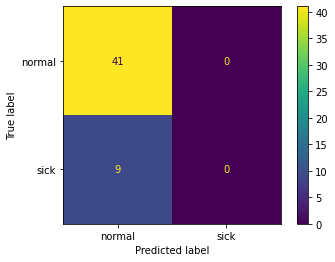

In [32]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels = class_names)
disp.plot()

plt.show()

In [33]:
from sklearn.metrics import classification_report
print(classification_report(predicted_labels,correct_labels))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        41
           1       0.00      0.00      0.00         9

    accuracy                           0.82        50
   macro avg       0.41      0.50      0.45        50
weighted avg       0.67      0.82      0.74        50



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predict New Data from DataSet_2

In [34]:
dataset_2 = "/content/drive/MyDrive/MASTERS DEGREE/Makerere Unversity/SEM 2/Deep Learning/dataset2"
test_ds2 = tf.keras.utils.image_dataset_from_directory(dataset_2,  shuffle=False,
  color_mode='rgb', image_size=(150, 150), batch_size=50)

Found 224 files belonging to 1 classes.


In [35]:
AUTOTUNE = tf.data.AUTOTUNE

test_ds2 = test_ds2.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
normalization_layer = layers.Rescaling(1./255)

In [37]:
normalized_ds2 = test_ds2.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds2))
first_image = image_batch[3]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.83133733


In [38]:
y_pred = []
y_true = []

for image_batch, label_batch in test_ds2:

  y_true.append(label_batch)

  predictions = model.predict(image_batch)

  y_pred.append(np.argmax(predictions, axis = -1))

correct_labels = tf.concat([item for item in y_true],axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis =0)

from sklearn.metrics._plot.confusion_matrix import confusion_matrix
test2_cm=confusion_matrix(predicted_labels,correct_labels)
print(test2_cm)

[[134   0]
 [ 90   0]]


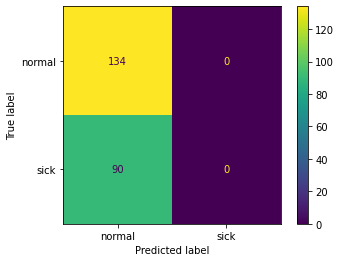

In [39]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=test2_cm, display_labels = class_names)
disp.plot()

plt.show()

Predictions Dataset2:
 [0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 1 1 1 0]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


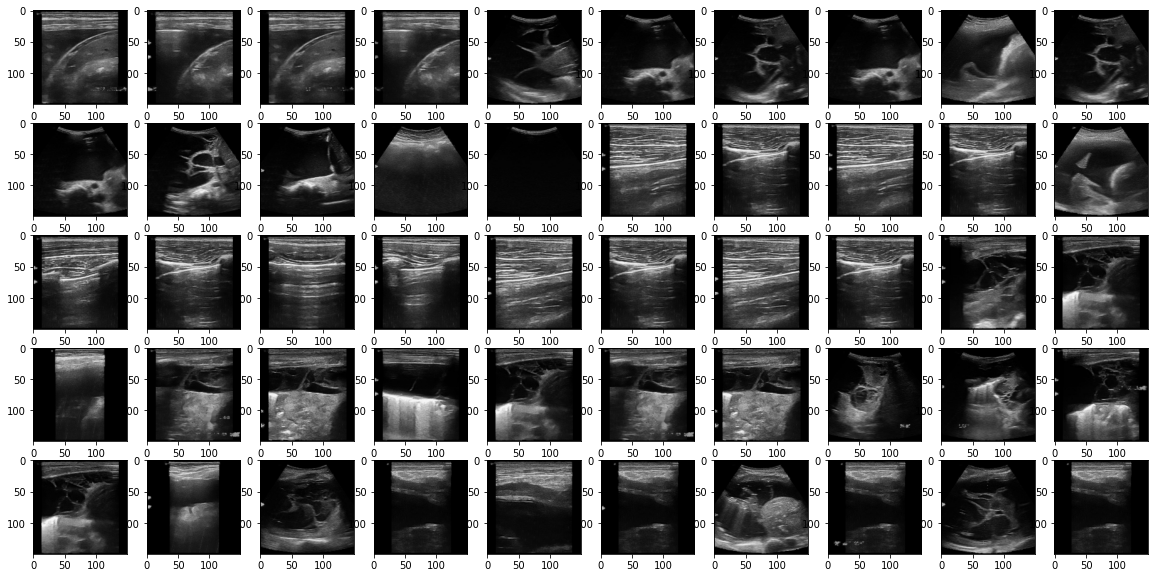

In [40]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds2.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions_ds2 = tf.math.argmax(predictions,1)
#predictions_ds2 = tf.where(predictions < 0.5, 0, 1)

print('Predictions Dataset2:\n', predictions_ds2.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 10))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))

In [41]:
# convert array into dataframe
DF = pd.DataFrame(predictions_ds2)
  
# save the dataframe as a csv file
DF.to_csv("image_results_ds2.csv")

In [42]:
test_loss,test_acc = model.evaluate(test_ds2,verbose=2)
print(test_loss)
print(test_acc)

5/5 - 0s - loss: 0.6743 - accuracy: 0.5982 - 82ms/epoch - 16ms/step
0.6742715239524841
0.5982142686843872


In [43]:
from sklearn.metrics import classification_report
print(classification_report(predicted_labels,correct_labels))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75       134
           1       0.00      0.00      0.00        90

    accuracy                           0.60       224
   macro avg       0.30      0.50      0.37       224
weighted avg       0.36      0.60      0.45       224



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
